In [1]:
from math import ceil, sqrt

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm

from llm_judge_reporting.calibration import point_estimator, confidence_interval, clip
from llm_judge_reporting.allocation import allocate_calibration_sample


matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams.update({"font.size": 16})
legend_fontsize = 14

In [2]:
def confidence_interval_for_p_hat(p, n, alpha=0.05):
    z = norm.ppf(1 - alpha/2)
    se = sqrt(p*(1-p)/n)
    return clip(p - z*se), clip(p + z*se)

def _calculate_result(theta, p_hat, q0_hat, q1_hat, n, m0, m1, alpha):
    result = {"theta":theta}

    result["theta_hat"] = point_estimator(p_hat, q0_hat, q1_hat)
    result["theta_lo"], result["theta_hi"] = confidence_interval(p_hat, q0_hat, q1_hat, n, m0, m1, alpha=alpha)
    result["theta_covered"] = (result["theta_lo"] <= theta) and (theta <= result["theta_hi"])

    result["p_hat"] = p_hat
    result["p_lo"], result["p_hi"] = confidence_interval_for_p_hat(p_hat, n, alpha=alpha)
    result["p_covered"] = (result["p_lo"] <= theta) and (theta <= result["p_hi"])

    return result

def simulate(theta, q0, q1, n, m, rng, m_pilot=10, alpha=0.05):
    assert m >= 2 * m_pilot, f"m must be at least {2 * m_pilot} to include the pilot samples"
    assert m % 2 == 0, "m must be an even integer"
    
    result = {"equal":{}, "adaptive":{}}

    ################
    # test dataset
    n_1 = rng.binomial(1, theta, size=n).sum() 
    p_hat = (rng.binomial(1, 1-q0, size=n-n_1).sum() + rng.binomial(1, q1, size=n_1).sum()) / n

    ################
    # calibration dataset
    # case1. eqaul sample size
    m0, m1 = int(m/2), int(m/2)
    q0_hat = rng.binomial(1, q0, size=m0).sum() / m0
    q1_hat = rng.binomial(1, q1, size=m1).sum() / m1

    result["equal"] = _calculate_result(theta, p_hat, q0_hat, q1_hat, n, m0, m1, alpha)
    
    # case2. adaptive allocation
    m0_q0_temp = rng.binomial(1, q0, size=m_pilot).sum()
    m1_q1_temp = rng.binomial(1, q1, size=m_pilot).sum()

    q0_temp = m0_q0_temp / m_pilot
    q1_temp = m1_q1_temp / m_pilot

    m0, m1 = allocate_calibration_sample(m, p_hat, q0_temp, q1_temp, m_pilot)

    q0_hat = (rng.binomial(1, q0, size=m0-m_pilot).sum() + m0_q0_temp) / m0
    q1_hat = (rng.binomial(1, q1, size=m1-m_pilot).sum() + m1_q1_temp) / m1

    result["adaptive"] = _calculate_result(theta, p_hat, q0_hat, q1_hat, n, m0, m1, alpha)

    return result

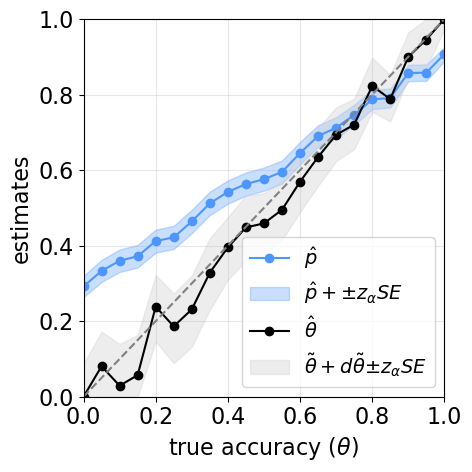

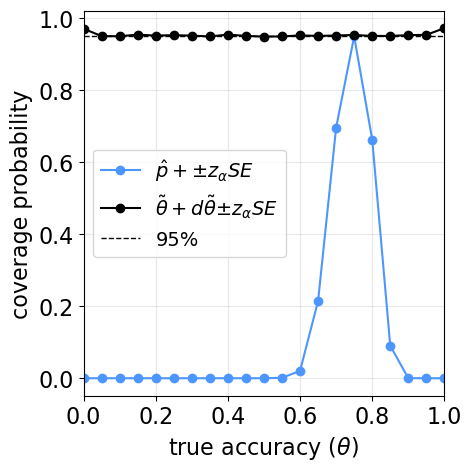

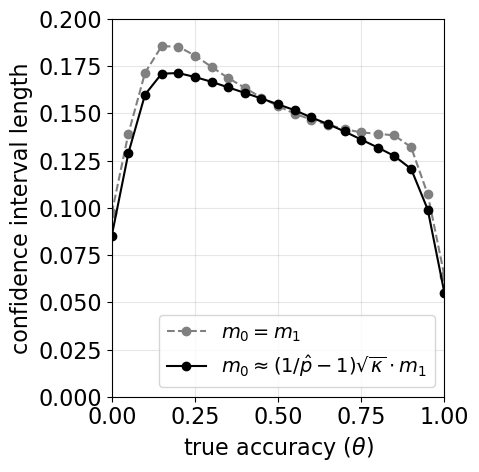

In [3]:
# setup
seed = 1234
replication = 10_000

# Parameters
thetas = np.linspace(0, 1, 21)
q0, q1 = (0.7, 0.9)

n = 1000
m = 500

# ===== Experiment =====
rng = np.random.default_rng(seed)

rows_equal = []
rows_adaptive = []

for theta in thetas:
    for _ in range(replication):
        result = simulate(theta, q0, q1, n, m, rng, m_pilot=10, alpha=0.05)
        rows_equal.append(result['equal'])
        rows_adaptive.append(result['adaptive'])

df_equal = pd.DataFrame(rows_equal)
df_adaptive = pd.DataFrame(rows_adaptive)

df_equal_no_replicate = df_equal.drop_duplicates(subset="theta", keep="first")

df_equal_mean = df_equal.groupby("theta").mean().reset_index()
df_adaptive_mean = df_adaptive.groupby("theta").mean().reset_index()


# ===== plots =====
# ---- Plot 1: Estimator & CI bounds vs theta ----
plt.figure(figsize=(5, 5))
plt.plot(df_equal_no_replicate.theta, df_equal_no_replicate.p_hat, "o-", label="$\hat{p}$", color="#4D96FF")
plt.fill_between(df_equal_no_replicate.theta, df_equal_no_replicate.p_lo, df_equal_no_replicate.p_hi, color="#4D96FF", alpha=0.3, label="$\hat{p}+{\pm}z_{\\alpha}SE$")
plt.plot(df_equal_no_replicate.theta, df_equal_no_replicate.theta_hat, "o-", label="$\hat{\\theta}$", color="black")
plt.fill_between(df_equal_no_replicate.theta, df_equal_no_replicate.theta_lo, df_equal_no_replicate.theta_hi, color="lightgray", alpha=0.4, label="$\\tilde{\\theta}+d\\tilde{\\theta}{\\pm}z_{\\alpha}SE$")
plt.plot([0,1],[0,1],"--", color="gray")

plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel(r"true accuracy ($\theta$)")
plt.ylabel(r"estimates")

plt.legend(loc='lower right', fontsize=legend_fontsize)
plt.grid(alpha=0.3); plt.tight_layout()
plt.show()
plt.close()

# ---- Plot 2: coverage probability ----
plt.figure(figsize=(5, 5))
plt.plot(df_equal_mean.theta, df_equal_mean.p_covered, marker="o", linestyle="-", color="#4D96FF", label="$\hat{p}+{\pm}z_{\\alpha}SE$")
plt.plot(df_equal_mean.theta, df_equal_mean.theta_covered, marker="o", linestyle="-", color="black", label="$\\tilde{\\theta}+d\\tilde{\\theta}{\\pm}z_{\\alpha}SE$")
plt.axhline(0.95, linestyle="--", linewidth=1, label="95%", color="black")

plt.xlim(0,1)
plt.xlabel(r"true accuracy ($\theta$)"); plt.ylabel(r"coverage probability")

plt.legend(fontsize=legend_fontsize)
plt.grid(alpha=0.3); plt.tight_layout()
plt.show()
plt.close()

# ---- Plot 3: The length of CI ----
plt.figure(figsize=(5, 5))
plt.plot(df_equal_mean.theta, df_equal_mean.theta_hi - df_equal_mean.theta_lo, "o--", label=f"$m_0=m_1$", color="gray")
plt.plot(df_adaptive_mean.theta, df_adaptive_mean.theta_hi - df_adaptive_mean.theta_lo, "o-", label=r"$m_0\approx (1/\hat{p}-1)\sqrt{\kappa} \cdot m_1$", color="black")

max_ylim = ceil(max((df_equal_mean.theta_hi - df_equal_mean.theta_lo).max(), (df_adaptive_mean.theta_hi - df_adaptive_mean.theta_lo).max()) * 20) / 20
plt.xlim(0,1); plt.ylim(0,max_ylim)
plt.xlabel(r"true accuracy ($\theta$)"); plt.ylabel(r"confidence interval length")

plt.legend(loc='lower right', fontsize=legend_fontsize)
plt.grid(alpha=0.3); plt.tight_layout()
plt.show()
plt.close()